# Digital Twin Demo (Confocal Microscopy)

This notebook demonstrates the `DigitalTwin` in `copilot/digital_twin.py`:

- Generate synthetic confocal stacks (colloidal gel and nuclei-like)
- Visualize depth-dependent intensity
- Use the parameter recommender on a noisy stack
- Sketch how to plug in a real dataset

You can run this in VS Code (Jupyter) or, after pushing to GitHub, open it in Colab via an “Open in Colab” badge in the README.


In [1]:
# Setup: repo root on sys.path (works in VS Code; Colab clone is optional)

import os, sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    # In Colab: clone your repo once, then cd into it
    if not os.path.exists("confocal_microscopy-copilot"):
        !git clone https://github.com/Abhishek-Gupta-GitHub/confocal_microscopy-copilot.git
    os.chdir("confocal_microscopy-copilot")

repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("Repo root:", repo_root)

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)


Repo root: c:\Users\akumarg\Desktop\microscopy hackathon\confocal_microscopy-copilot


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copilot.digital_twin import DigitalTwin  # this should now work

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["image.cmap"] = "magma"


## 1. Imports and helpers

Import the digital twin and define a small plotting helper to inspect single frames or z-slices from 3D+time stacks.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from copilot.digital_twin import DigitalTwin

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["image.cmap"] = "magma"

def show_frame(stack, frame_idx=0, z_idx=None, title=""):
    """Visualize a single frame or z-slice from a 4D stack (T, Z, Y, X)."""
    stack = np.asarray(stack)
    if stack.ndim != 4:
        raise ValueError("Expected stack shape (T, Z, Y, X)")
    t = min(frame_idx, stack.shape[0] - 1)
    if z_idx is None:
        z = stack.shape[1] // 2
    else:
        z = min(z_idx, stack.shape[1] - 1)
    img = stack[t, z]
    plt.imshow(img)
    plt.colorbar(label="Intensity")
    plt.title(title or f"frame={t}, z={z}")
    plt.axis("off")
    plt.show()


## 2. Microscope and sample presets

Here we define:

- A base confocal microscope configuration (NA, wavelength, voxel size, PSF mode).
- Two sample presets:
  - **Colloidal gel**: many beads, viscoelastic motion, near-wall hindrance.
  - **Nuclei-like**: fewer, brighter objects with mostly viscous motion.

The same forward model will be used for both, only configs change.


In [9]:
# Base microscope configuration (dict -> MicroscopeConfig inside twin)

base_microscope = {
    "na": 1.3,
    "wavelength_nm": 550.0,
    "immersion_ri": 1.33,
    "sample_ri": 1.33,
    "pixel_size_xy_um": 0.1,
    "z_step_um": 0.2,
    "img_shape_xyz": (32, 96, 96),  # (Z, Y, X)
    "psf_mode": "gaussian_confocal",
    # optional “acquisition-like” fields for recommender
    "exposure_ms": 5.0,
    "pinhole_factor": 1.0,
    "z_att_um": 50.0,
    "bleach_tau_s": 80.0,
    "noise_std": 5.0,
}

# Colloidal gel: many beads, viscoelastic, near wall
colloidal_sample = {
    "n_particles": 400,
    "box_size_um": (30.0, 30.0, 30.0),
    "motion_model": "viscoelastic_near_wall",
    "D": 0.1,
    "D0": 0.15,
    "alpha": 0.6,
    "z_wall_um": 0.0,
    "z_cut_um": 4.0,
    "brightness": 1.0,
}

# Nuclei-like sample: fewer, brighter, mostly viscous
nuclei_sample = {
    "n_particles": 80,
    "box_size_um": (40.0, 40.0, 40.0),
    "motion_model": "viscous",
    "D": 0.05,
    "D0": 0.05,
    "alpha": 1.0,
    "z_wall_um": 0.0,
    "z_cut_um": 6.0,
    "brightness": 3.0,
}

twin = DigitalTwin()


## 3. Simulate a colloidal gel stack

Simulate a 3D+time confocal movie for the colloidal gel preset and visualize:

- One frame at the mid z-plane.
- The depth profile (mean intensity vs z) at time 0, which reflects PSF blur and depth-dependent attenuation.


Colloidal stack shape: (20, 32, 96, 96)


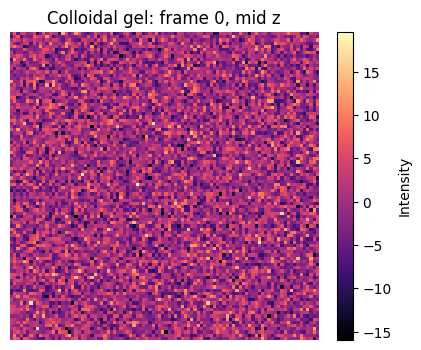

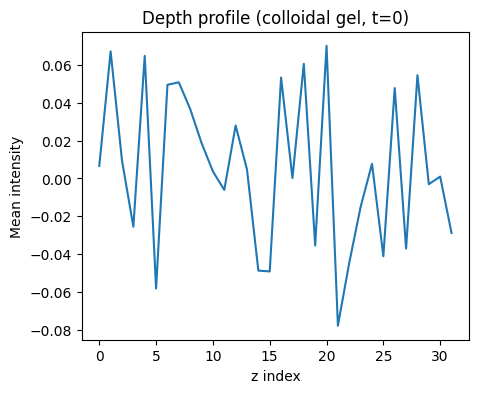

In [10]:
n_frames = 20
dt = 0.1  # seconds

stack_colloid, pos_colloid = twin.simulate(
    microscope_config=base_microscope,
    sample_config=colloidal_sample,
    n_frames=n_frames,
    dt=dt,
)

print("Colloidal stack shape:", stack_colloid.shape)
show_frame(stack_colloid, frame_idx=0, z_idx=None, title="Colloidal gel: frame 0, mid z")

# Depth profile at t=0
depth_profile = stack_colloid[0].mean(axis=(1, 2))
plt.plot(depth_profile)
plt.xlabel("z index")
plt.ylabel("Mean intensity")
plt.title("Depth profile (colloidal gel, t=0)")
plt.show()


## 4. Simulate a nuclei-like stack

Now switch only the sample configuration to a nuclei-like preset. The call to `DigitalTwin.simulate` stays the same, showing how presets generalize across soft-matter and biological use cases.


Nuclei stack shape: (20, 32, 96, 96)


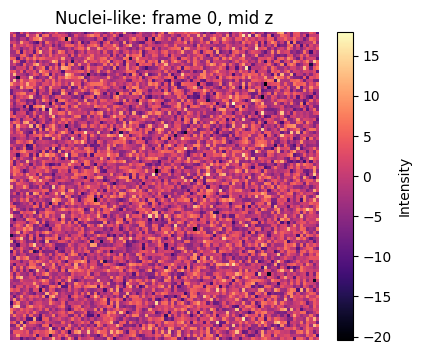

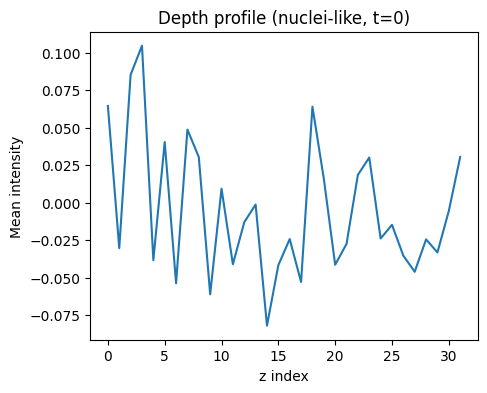

In [11]:
stack_nuclei, pos_nuclei = twin.simulate(
    microscope_config=base_microscope,
    sample_config=nuclei_sample,
    n_frames=n_frames,
    dt=dt,
)

print("Nuclei stack shape:", stack_nuclei.shape)
show_frame(stack_nuclei, frame_idx=0, z_idx=None, title="Nuclei-like: frame 0, mid z")

depth_profile_n = stack_nuclei[0].mean(axis=(1, 2))
plt.plot(depth_profile_n)
plt.xlabel("z index")
plt.ylabel("Mean intensity")
plt.title("Depth profile (nuclei-like, t=0)")
plt.show()


## 5. Parameter recommender on a noisy stack

Treat the colloidal stack as a noisy “real” dataset and run:

- `DigitalTwin.recommend_parameters` over a small grid of exposure times and pinhole factors.
- The twin simulates test stacks, compares simple metrics (SNR, contrast), and suggests acquisition changes.

In the full copilot, this output can be passed to the LLM explainer and the GUI as a “twin suggestion” panel.


In [12]:
suggestion = twin.recommend_parameters(
    real_stack=stack_colloid,
    base_microscope_config=base_microscope,
    sample_config=colloidal_sample,
    n_frames_test=6,
    dt=dt,
    exposure_candidates_ms=[5.0, 10.0, 20.0],
    pinhole_factors=[1.0, 0.7],
)

print("Recommendation:\n", suggestion["recommendation"])
print("\nBase metrics:")
for k, v in suggestion["base_metrics"].items():
    print(f"  {k}: {v:.3f}")

print("\nBest candidate:")
for k, v in suggestion["best_candidate"].items():
    if isinstance(v, dict):
        print(f"  {k}:")
        for kk, vv in v.items():
            print(f"    {kk}: {vv:.3f}")
    else:
        print(f"  {k}: {v}")


Recommendation:
 Current settings are near optimal under this twin model.

Base metrics:
  mean_intensity: 0.004
  std_intensity: 5.004
  snr: 0.001
  contrast: 1425.180

Best candidate:
  exposure_ms: 5.0
  pinhole_factor: 1.0
  sim_metrics:
    mean_intensity: 0.011
    std_intensity: 4.985
    snr: 0.002
    contrast: 434.930


## 6. Sketch: using a real dataset

For now, this section uses a placeholder loader that returns the synthetic stack. To integrate real confocal data:

- Replace `load_example_real_stack` with a TIFF/OME loader.
- Map your voxel sizes and NA into `base_microscope`.
- Call `recommend_parameters` exactly as above.

This is the hook where your GUI can run the twin on user-uploaded data and display parameter suggestions.


In [13]:
from pathlib import Path

def load_example_real_stack(path: str) -> np.ndarray:
    """
    TODO: replace with a real OME-TIFF / HDF5 loader.
    For now, just return the synthetic colloidal stack as a stand-in.
    """
    _ = path
    return stack_colloid.copy()

data_path = "data/example_real_stack.tif"  # adjust to your real dataset
real_stack = load_example_real_stack(data_path)
print("Real stack (placeholder) shape:", real_stack.shape)

real_suggestion = twin.recommend_parameters(
    real_stack=real_stack,
    base_microscope_config=base_microscope,
    sample_config=colloidal_sample,
    n_frames_test=6,
    dt=dt,
)

print("\nReal-data suggestion (placeholder IO):")
print(real_suggestion["recommendation"])


Real stack (placeholder) shape: (20, 32, 96, 96)

Real-data suggestion (placeholder IO):
Current settings are near optimal under this twin model.
